# **Predictive Analysis #3**

>***UC-Irvine Online Shoppers Purchasing Intention Dataset***

In Predictive Analysis#1 we used all 17 available independent variables, In Predictive Analysis#2 we used 14 independent variables in the machine learning models. In this step, we will apply another feature selection method: ***Information Gain*** alongside corrolation.

#Importing libraries and dataset

**Importing required libraries**

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import copy

from sklearn.utils import indexable, check_random_state, shuffle
from pandas.core.frame import DataFrame
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import plot_confusion_matrix


**Reading the dataset to Pandas dataframe**

In [32]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
df_original = pd.read_csv (url)

#Feature Selection

**In this section we will create a copy of original dataset, prepare the data, and apply feature selection.This copy will only will be used for feature selection, and not in any modelling**

In [33]:
df_extra= df_original.copy()

**Applying Information Gain using mutual_class_info from scikit learn library, we can only use discrete variables with this method.** 

In [34]:
df_extra.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

**Therefore we will transform the categorical variables to discrete variables before applying the technique. Let's drop the continous variables and transfer the categorical object and bool types to discrete variables**

In [35]:
#dropping the continous variables 
df_extra.drop(["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", 
               "BounceRates", "ExitRates", "PageValues", "SpecialDay"], axis=1, inplace=True)

#converting Month names to the corresponding numbers
Month={'Feb':2, 'Mar':3, 'May':5, 'Oct':10, 'June':6, 'Jul':7, 'Aug':8, 'Nov':11, 'Sep':9,'Dec':12}
df_extra['Month']=df_extra['Month'].map(Month)

#converting visitor types to integers
VisitorType={'Returning_Visitor':1, 'New_Visitor':2, 'Other':3}
df_extra['VisitorType']=df_extra['VisitorType'].map(VisitorType)

#for "Weekend" and "Revenue" we can just replace True and False with 1 & 0 respectively 
df_extra.replace({True:1,False:0})

,Administrative,Informational,ProductRelated,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0,1,2,1,1,1,1,1,0,0
1,0,0,2,2,2,2,1,2,1,0,0
2,0,0,1,2,4,1,9,3,1,0,0
3,0,0,2,2,3,2,2,4,1,0,0
4,0,0,10,2,3,3,1,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
12325,3,0,53,12,4,6,1,1,1,1,0
12326,0,0,5,11,3,2,1,8,1,1,0
12327,0,0,6,11,3,2,1,13,1,1,0
12328,4,0,15,11,2,2,3,11,1,0,0


**Now we will apply our feature selection method using Mutual Information for Classification**

In [36]:
from pandas.errors import InvalidIndexError
from numpy.ma.core import ravel
from sklearn.feature_selection import mutual_info_classif
#subsetting the dataset as dependenat and independent variables 
X=df_extra.iloc[:,0:10]
y=df_extra.iloc[:,-1:]
y = y.values.ravel()

#applying feature selection for classification  
importances= mutual_info_classif(X=X,y=y, random_state=37)
feat_importances = pd.Series(importances, df_extra.columns[0:len(df_extra.columns)-1]).sort_values()
#printing the results 
feat_importances

Region              0.001133
VisitorType         0.003213
Browser             0.003412
OperatingSystems    0.003905
Weekend             0.005399
Informational       0.005687
Administrative      0.012895
Month               0.014626
TrafficType         0.015314
ProductRelated      0.025175
dtype: float64

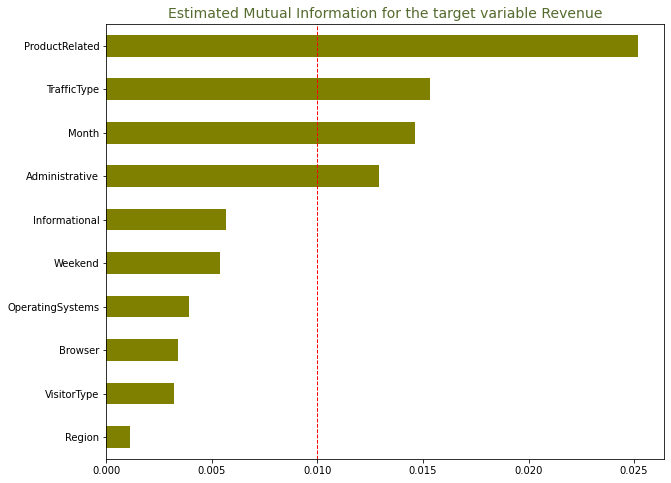

In [37]:
#plotting the results of feature selection 
plt.figure(figsize = (10,8))
feat_importances.plot(kind="barh", color= "olive")
threshold=0.01
plt.axvline(x=threshold,linewidth=1, color='red', linestyle='dashed')
plt.title("Estimated Mutual Information for the target variable Revenue", fontsize=14, color="darkolivegreen")
plt.show()

**By combining the results from Information Gain (setting the treshold at min: 0.01) and Corrolation we remove the following features prior to modelling:**
* **Region**: based on Chi-Squared test and IG results 
* **VisitorType**: Removing all based on IG result
* **Browser**: based on IG results
* **OperatingSystems**: based on IG results
* **Weekend**: based on IG results
* **Informational**: based on IG results
* **ProductRelated_Duration**: based on IG results and high Corrolation with "ProductRelated"
* **BounceRates**: The feature was highly coorolated with ExitRates, based on both higher variance and higher mutual information of ExitRates, we remove BounceRates.

# Preprocessing the dataset

**Making a copy to keep the original if needed.**

In [38]:
df_c=df_original.copy()

In [39]:
#defning the list of features to be removed
excluded_features = ["Region", "VisitorType","Browser", "Weekend","OperatingSystems",
                     "Informational", "ProductRelated_Duration", "BounceRates"]

#dropping the above features 
df_c=df_c.drop(columns=excluded_features)

**Data Normalization**

In [40]:
from sklearn.preprocessing import Normalizer
#defining the preprocessor 
Normalizer=Normalizer()

#creating a list of numerical features 
numeric_features = ["Administrative", "Administrative_Duration", 
                    "Informational_Duration", "ProductRelated", 
                    "ExitRates", "PageValues", "SpecialDay", 
                    "TrafficType"]

#normalizing the numerical features 
df_c[numeric_features]=Normalizer.fit_transform(df_c[numeric_features])


**Creating a temporary dataframe from only the dependent variable so it can be re-added as the last column of the finalized dataframe**

In [41]:
y=df_c[["Revenue"]]


**Transforming the non-numeric categorical feature Month to dummy variables**

In [42]:
#Defining dummy values for all non-numeric  categorical variables 
Month=pd.get_dummies(df_c["Month"], drop_first=True)

**Dropping the original variable "Month", and dependent variable (so it can be added back as the last column)**

In [43]:
#dropping the original variable, and dependent variable (so it can be added back as the last column)
df_c.drop(["Month", "Revenue"], axis=1, inplace=True)

**Adding the newly created dummy variables to the dataset, and adding dependent variable to the end**

In [44]:
#adding the newly created dummy variables to the dataset, and adding dependent variable to the end
df_c=pd.concat([df_c, Month, y],axis=1)

**Let's take a look at the transformed dataset before we proceed**

In [45]:
df_c

,Administrative,Administrative_Duration,Informational_Duration,ProductRelated,ExitRates,PageValues,SpecialDay,TrafficType,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep,Revenue
0,0.000000,0.000000,0.0,0.700140,0.140028,0.00000,0.0,0.700140,0,1,0,0,0,0,0,0,0,False
1,0.000000,0.000000,0.0,0.706665,0.035333,0.00000,0.0,0.706665,0,1,0,0,0,0,0,0,0,False
2,0.000000,0.000000,0.0,0.315597,0.063119,0.00000,0.0,0.946792,0,1,0,0,0,0,0,0,0,False
3,0.000000,0.000000,0.0,0.446995,0.031290,0.00000,0.0,0.893989,0,1,0,0,0,0,0,0,0,False
4,0.000000,0.000000,0.0,0.928467,0.004642,0.00000,0.0,0.371387,0,1,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.019367,0.936091,0.0,0.342157,0.000187,0.07903,0.0,0.006456,1,0,0,0,0,0,0,0,0,False
12326,0.000000,0.000000,0.0,0.529998,0.002261,0.00000,0.0,0.847996,0,0,0,0,0,0,1,0,0,False
12327,0.000000,0.000000,0.0,0.419051,0.006053,0.00000,0.0,0.907943,0,0,0,0,0,0,1,0,0,False
12328,0.051696,0.969296,0.0,0.193859,0.000272,0.00000,0.0,0.142163,0,0,0,0,0,0,1,0,0,False


#ML Parameters

* **we set random state for the result to be repeatable**

In [46]:
# Set a Random State 
rng = np.random.RandomState(0)


* **Let's separate our dependent variable, and split our data to train set and test set.** 
* **we will keep this 20% test set to evaluate and compare the performance of  all models.**

In [47]:
from sklearn.model_selection import train_test_split
# Divide X and y (separating dependent variable from independent variables)
y = df_c['Revenue']
X = df_c.drop(['Revenue'], axis=1)

# Split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=rng)

* **We will use Accuracy,precision, recall, F1 score, and AUC-ROC(Area Under the Curve of Receiver Operating Characteristics) as evaluation measure to compare our models.**
* **We are also using 10 fold cross validation, repeated 3 times, to train our models. Please note we set randm_state to ensure our folds stay the same for all models.**

In [48]:
#creating a list of evaluation measures to pass on to ML pipelines
scoring = ('roc_auc','accuracy','precision','recall', "f1")

#creating repeated K fold Cross validation with random state to pass on to ML pieplines 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=rng)


**As shown in the EDA, our data set is extremely imbalanced. Hence, we will apply SMOTE on our train dataset before training each model by adding the SMOTE function to all our Machine Learning pieplines.**

#XGB Classifier

**Let's pass on the data to XGB (Extreme Gradient Boosting) Classifier**

In [49]:
#defining the classifier 
XGB=XGBClassifier(eval_metric='logloss', max_depth=27)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", XGB)]

#defining the pipeline
clf_XGB= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_XGB = cross_validate(clf_XGB, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_XGB.items():
    print(k, np.round(v.mean(),4))


fit_time 9.529
score_time 0.044
test_roc_auc 0.9175
test_accuracy 0.8755
test_precision 0.5662
test_recall 0.7509
test_f1 0.6449


* **We see the evaluation on our training dataset.**

**In the next step, we pass on the test set to our model, and calculate the evaluation measures using the test set which would be the measures to compare the performance of the models** 

In [50]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
XGB_fit=XGB.fit(X_train, y_train)


**Predicting the independent variable "Revenue" using test set**

In [51]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_XGB = XGB_fit.predict(X_test)

**Displaying the results as Confusion Matrix**

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Confusion Matrix
cm_XGB=confusion_matrix(y_test, y_pred_XGB)
cm_XGB

array([[1937,  107],
       [ 200,  222]])

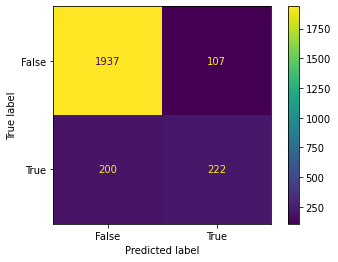

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_XGB);

**Let's get the evaluation measures for the model:**

In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
#getting the evaluation measures for test set
XGB_Metrics= classification_report(y_test, y_pred_XGB, digits=3)
XGB_ROC_AUC= round(roc_auc_score(y_test, y_pred_XGB),3)

#printing the evaluation measures for test set
print("XGBClassifier\n\n", XGB_Metrics)
print("roc_auc    ", XGB_ROC_AUC )

XGBClassifier

               precision    recall  f1-score   support

       False      0.906     0.948     0.927      2044
        True      0.675     0.526     0.591       422

    accuracy                          0.876      2466
   macro avg      0.791     0.737     0.759      2466
weighted avg      0.867     0.876     0.869      2466

roc_auc     0.737


**Saving the model performance result in a dictionary**

In [55]:
#saving the model performance result in a dictionary for easy future access
XGB_report= classification_report(y_test, y_pred_XGB, digits=3, output_dict=True)


**NOTE: All the above steps will be repeated for each model.**

**For this model, let's plot the XGB tree!**

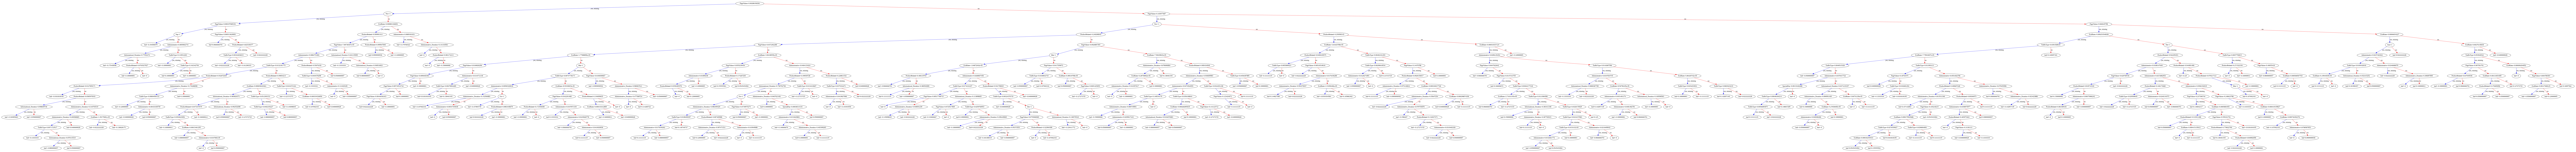

In [56]:
from xgboost import plot_tree
#Plotting the XGB tree
plot_tree(XGB);
fig = plt.gcf()
fig.set_size_inches(300, 300)
fig.savefig('XGBtree.png')

#Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier

#defining the classifier 
RF=RandomForestClassifier(random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", RF)]

#defining the pipeline
clf_RF= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_RF = cross_validate(clf_RF, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_RF.items():
    print(k, np.round(v.mean(),4))

fit_time 2.6507
score_time 0.0824
test_roc_auc 0.9164
test_accuracy 0.8795
test_precision 0.5741
test_recall 0.773
test_f1 0.6583


In [58]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
RF_fit=RF.fit(X_train, y_train)

In [59]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_RF = RF_fit.predict(X_test)

In [60]:
# Confusion Matrix
cm_RF=confusion_matrix(y_test, y_pred_RF)
cm_RF

array([[1949,   95],
       [ 198,  224]])

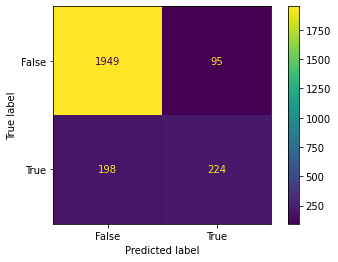

In [61]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF);

In [62]:
#getting the evaluation measures for test set
RF_Metrics= classification_report(y_test, y_pred_RF, digits=3)
RF_ROC_AUC= round(roc_auc_score(y_test, y_pred_RF),3)

#printing the evaluation measures for test set
print("RandomForestClassifier\n\n", RF_Metrics)
print("roc_auc    ", RF_ROC_AUC )

RandomForestClassifier

               precision    recall  f1-score   support

       False      0.908     0.954     0.930      2044
        True      0.702     0.531     0.605       422

    accuracy                          0.881      2466
   macro avg      0.805     0.742     0.767      2466
weighted avg      0.873     0.881     0.874      2466

roc_auc     0.742


In [63]:
#saving the model performance result in a dictionary for easy future access
RF_report= classification_report(y_test, y_pred_RF, digits=3, output_dict=True)

#Desicion Tree Classifier

In [64]:
#defining the classifier 
DT=DecisionTreeClassifier(random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", DT)]

#defining the pipeline
clf_DT= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_DT = cross_validate(clf_DT, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_DT.items():
    print(k, np.round(v.mean(),4))

fit_time 0.2375
score_time 0.0095
test_roc_auc 0.7795
test_accuracy 0.8534
test_precision 0.5101
test_recall 0.6703
test_f1 0.5786


In [65]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
DT_fit= DT.fit(X_train, y_train)


In [66]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_DT = DT_fit.predict(X_test)

In [67]:
# Confusion Matrix
cm_DT=confusion_matrix(y_test, y_pred_DT)
cm_DT

array([[1892,  152],
       [ 210,  212]])

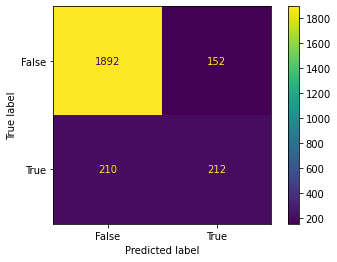

In [68]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_DT);

In [69]:
#getting the evaluation measures for test set
DT_Metrics= classification_report(y_test, y_pred_DT, digits=3)
DT_ROC_AUC= round(roc_auc_score(y_test, y_pred_DT),3)

#printing the evaluation measures for test set
print("DecisionTreeClassifier\n\n", DT_Metrics)
print("roc_auc    ", DT_ROC_AUC )

DecisionTreeClassifier

               precision    recall  f1-score   support

       False      0.900     0.926     0.913      2044
        True      0.582     0.502     0.539       422

    accuracy                          0.853      2466
   macro avg      0.741     0.714     0.726      2466
weighted avg      0.846     0.853     0.849      2466

roc_auc     0.714


In [70]:
#saving the model performance result in a dictionary for easy future access
DT_report= classification_report(y_test, y_pred_DT, digits=3, output_dict=True)

#Support Vector Classification

In [71]:
from sklearn import svm

#defining the classifier 
SVC_L=svm.SVC(kernel='linear', random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", SVC_L)]

#defining the pipeline
clf_SVC_L= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_SVC_L = cross_validate(clf_SVC_L, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_SVC_L.items():
    print(k, np.round(v.mean(),4))

fit_time 5.22
score_time 0.3615
test_roc_auc 0.8989
test_accuracy 0.8244
test_precision 0.4515
test_recall 0.7603
test_f1 0.5658


In [72]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
SVC_fit=SVC_L.fit(X_train, y_train)


In [73]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_SVC_L = SVC_fit.predict(X_test)

In [74]:
# Confusion Matrix
cm_SVC_L=confusion_matrix(y_test, y_pred_SVC_L)
cm_SVC_L

array([[2000,   44],
       [ 277,  145]])

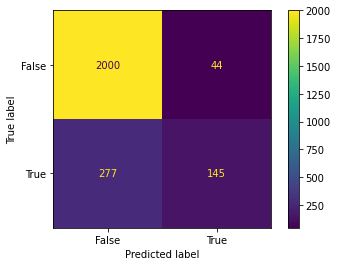

In [75]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_SVC_L);

In [76]:
#getting the evaluation measures for test set
SVC_L_Metrics= classification_report(y_test, y_pred_SVC_L, digits=3)
SVC_L_ROC_AUC= round(roc_auc_score(y_test, y_pred_SVC_L),3)

#printing the evaluation measures for test set
print("Support Vector Classification \n\n", SVC_L_Metrics)
print("roc_auc    ", SVC_L_ROC_AUC )

Support Vector Classification 

               precision    recall  f1-score   support

       False      0.878     0.978     0.926      2044
        True      0.767     0.344     0.475       422

    accuracy                          0.870      2466
   macro avg      0.823     0.661     0.700      2466
weighted avg      0.859     0.870     0.849      2466

roc_auc     0.661


In [77]:
#saving the model performance result in a dictionary for easy future access
SVC_L_report= classification_report(y_test, y_pred_SVC_L, digits=3, output_dict=True)

#LogisticRegression

In [78]:
from sklearn.linear_model import LogisticRegression

#defining the classifier 
LR=LogisticRegression(random_state=rng, max_iter=2000)

#steps in the pipeline 
steps=[('SMOTE', SMOTE( random_state=rng)),("classifier", LR)]

#defining the pipeline
clf_LR= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_LR = cross_validate(clf_LR, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_LR.items():
    print(k, np.round(v.mean(),4))

fit_time 0.3627
score_time 0.0142
test_roc_auc 0.8955
test_accuracy 0.829
test_precision 0.4591
test_recall 0.7569
test_f1 0.571


In [79]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
LR_fit=LR.fit(X_train, y_train)

In [80]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_LR = LR_fit.predict(X_test)

In [81]:
# Confusion Matrix
cm_LR=confusion_matrix(y_test, y_pred_LR)
cm_LR

array([[1994,   50],
       [ 269,  153]])

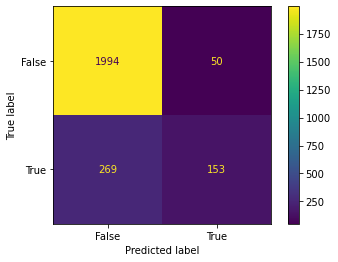

In [82]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_LR);

In [83]:
#getting the evaluation measures for test set
LR_Metrics= classification_report(y_test, y_pred_LR, digits=3)
LR_ROC_AUC= round(roc_auc_score(y_test, y_pred_LR),3)

#printing the evaluation measures for test set
print("Logistic Regression Classifier \n\n", LR_Metrics)
print("roc_auc    ", LR_ROC_AUC )

Logistic Regression Classifier 

               precision    recall  f1-score   support

       False      0.881     0.976     0.926      2044
        True      0.754     0.363     0.490       422

    accuracy                          0.871      2466
   macro avg      0.817     0.669     0.708      2466
weighted avg      0.859     0.871     0.851      2466

roc_auc     0.669


In [84]:
#saving the model performance result in a dictionary for easy future access
LR_report= classification_report(y_test, y_pred_LR, digits=3, output_dict=True)

#Comparing the Models 

In [85]:
from tabulate import tabulate

In [86]:
#create data
data = [["XGB", XGB_report["accuracy"], XGB_report["False"]["recall"],
         XGB_report["True"]["recall"], XGB_report["False"]["precision"], 
         XGB_report["True"]["precision"], XGB_report["False"]["f1-score"], 
         XGB_report["True"]["f1-score"], XGB_ROC_AUC],
        
        ["RF", RF_report["accuracy"], RF_report["False"]["recall"], 
         RF_report["True"]["recall"], RF_report["False"]["precision"], 
         RF_report["True"]["precision"], RF_report["False"]["f1-score"], 
         RF_report["True"]["f1-score"], RF_ROC_AUC], 
        
        ["DT", DT_report["accuracy"], DT_report["False"]["recall"], 
         DT_report["True"]["recall"], DT_report["False"]["precision"], 
         DT_report["True"]["precision"], DT_report["False"]["f1-score"], 
         DT_report["True"]["f1-score"], DT_ROC_AUC], 
        
        ["SVC_L", SVC_L_report["accuracy"], 
         SVC_L_report["False"]["recall"], SVC_L_report["True"]["recall"], 
         SVC_L_report['False']["precision"], SVC_L_report["True"]["precision"],
         SVC_L_report["False"]["f1-score"], SVC_L_report["True"]["f1-score"], 
         SVC_L_ROC_AUC],
        
        ["Logit", LR_report["accuracy"], LR_report["False"]["recall"], 
         LR_report["True"]["recall"], LR_report["False"]["precision"], 
         LR_report["True"]["precision"], LR_report["False"]["f1-score"], 
         LR_report["True"]["f1-score"], LR_ROC_AUC]]
  
#define header names
col_names = ["Classifier", "Accuracy", "Recall(F)", 
             "Recall(T)", "Precision(F)",
             "Precision(T)", "F1(F)", 
             "F1(T)", "ROC_AUC"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒══════════════╤════════════╤═════════════╤═════════════╤════════════════╤════════════════╤══════════╤══════════╤═══════════╕
│ Classifier   │   Accuracy │   Recall(F) │   Recall(T) │   Precision(F) │   Precision(T) │    F1(F) │    F1(T) │   ROC_AUC │
╞══════════════╪════════════╪═════════════╪═════════════╪════════════════╪════════════════╪══════════╪══════════╪═══════════╡
│ XGB          │   0.875507 │    0.947652 │    0.526066 │       0.906411 │       0.674772 │ 0.926573 │ 0.591212 │     0.737 │
├──────────────┼────────────┼─────────────┼─────────────┼────────────────┼────────────────┼──────────┼──────────┼───────────┤
│ RF           │   0.881184 │    0.953523 │    0.530806 │       0.907778 │       0.702194 │ 0.930088 │ 0.604588 │     0.742 │
├──────────────┼────────────┼─────────────┼─────────────┼────────────────┼────────────────┼──────────┼──────────┼───────────┤
│ DT           │   0.853204 │    0.925636 │    0.50237  │       0.900095 │       0.582418 │ 0.912687 │ 0.53944  │     

**In this analysis we used 9 independent variables (out of 17 in the original dataset)**